# NLP Disaster Tweets Kaggle Mini-Project 

## Overview
This notebook is a practice of utilizing the TensorFlow and Keras to build a Neural Network (NN) to identify false and real emergency alert from the post on Twitter. The practice is based on a Kaggle competition, and the data can be obtained from the competition website at https://www.kaggle.com/competitions/nlp-getting-started/data.

This notebook can also be found at https://github.com/Lorby04/msds/tree/main/dl/week4


1. Data preparing

Downloading data from the source, extract the compressed files to local disk.
The data includes 3 csv files, one includes the training data, and one includes the testing data, another one is a sample file.
We will use the training data to train the model and then make estimation on the testing data.

In [1]:
import pathlib
import os
import pandas as pd

import re
import shutil
import string

In [2]:
data_dir = "./nlp-getting-started"

train_csv = data_dir + "/train.csv"
test_csv = data_dir + "/test.csv"

train_df = None
test_df = None

In [3]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

dir_true = train_dir + "/1"
dir_false = train_dir + "/0"

train_path = pathlib.Path(train_dir).with_suffix('')
test_path = pathlib.Path(test_dir).with_suffix('')

Download data, create pandas dataframe from the csv files.

In [4]:
def download_data():
  dataset_url =  "https://www.kaggle.com/competitions/nlp-getting-started/data"
  cmd = "pip install opendatasets"
  os.system(cmd)
  import opendatasets as od
  od.download(dataset_url)


In [5]:
if not os.path.exists(data_dir):
  download_data()

In [6]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

## Exploratory Data Analysis (EDA)
Firstly, have a glance on the training data. It includes 7613 observations and 5 features. Among these features, most of the observations of 'keywords' and 'location' are not available. So these 2 features will not be considered in the training. The 'id' field is for indexing only, it is not needed for training.
The 'text' is the input data and the 'target' field is output data. 
Further check on the values of the feature 'target', it has 2 unique values: 0 means false alert and 1 means true alert.
There are 3263 rows of data for testing.
From the statistics information, 57% of the training data are false alerts and the other 43% are true alerts.

In [7]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [9]:
train_df[train_df['target']==1]['text'].values[100]

'Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/X2Qsjod40u #worldnews'

In [10]:
train_df[train_df['target']!=1]['text'].values[100]

"@Kiwi_Karyn Check out what's in my parking lot!! He said that until last year it was an ambulance in St Johns. http://t.co/hPvOdUD7iP"

In [11]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

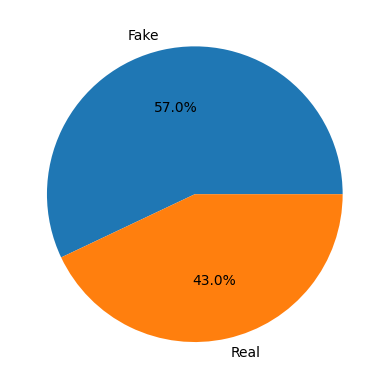

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['Fake', 'Real']
plt.pie(train_df['target'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

The tensorflow dataset API text_dataset_from_directory requires the training data to be organized in a hierarchical structure with the sundir name being the name of the category. To follow the requirement of the API, the 'text' field in the dataframe are copied to txt file respectively.

In [13]:
#Convert the image from tif to jpg
#Move train data to subclass directory
def new_dir(directory):
  cmd = "mkdir " + directory
  os.system(cmd)

def prepare_data():
  new_dir(train_dir)
  new_dir(test_dir)
  new_dir(dir_true)
  new_dir(dir_false)

  #extract the training data
  for row in train_df.itertuples(index = False):
    txt = "/" + str(row.id) + ".txt" 
    if row.target == 0:
      txt = dir_false + txt
    else:
      txt = dir_true + txt
    
    with open(txt, 'w') as f:
      f.write(row.text)

  #extract the testing data 
  for row in test_df.itertuples(index = False):
    txt = test_dir + "/" + str(row.id) + ".txt" 

    with open(txt, 'w') as f:
      f.write(row.text)

  

In [14]:
if not os.path.exists(train_dir):
    prepare_data()

Cross check the raw data with the files in the traning directory. The data matches with the csv file.

In [15]:
list(train_path.iterdir())

[PosixPath('nlp-getting-started/train/.DS_Store'),
 PosixPath('nlp-getting-started/train/0'),
 PosixPath('nlp-getting-started/train/1')]

In [16]:
txt_true = list((pathlib.Path(dir_true).with_suffix('')).glob('*.txt'))
txt_count_true = len(txt_true)
assert(txt_count_true == train_df['target'].value_counts()[1])
print("Number of text with real emergency:",txt_count_true)

txt_false = list((pathlib.Path(dir_false).with_suffix('')).glob('*.txt'))
txt_count_false = len(txt_false)
assert(txt_count_false == train_df['target'].value_counts()[0])
print("Number of text with false alarm:",txt_count_false)

txt_test = list((pathlib.Path(test_dir).with_suffix('')).glob('*.txt'))
txt_count_test = len(txt_test)
assert(txt_count_test == len(test_df))
print("Number of text for testing:",txt_count_test)

Number of text with real emergency: 3271
Number of text with false alarm: 4342
Number of text for testing: 3263


In [17]:
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

Generate training and validation dataset with text_dataset_from_directory

In [18]:
class_names = ['0', '1']
batch_size = 32
orig_train_ds = tf.keras.utils.text_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size)


Found 7613 files belonging to 2 classes.
Using 6091 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-16 23:58:47.893271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 23:58:47.893293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
orig_val_ds = tf.keras.utils.text_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Found 7613 files belonging to 2 classes.
Using 1522 files for validation.


In [20]:
print(orig_train_ds, "\n", orig_val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
 <BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Check the dataset is as expected.

In [21]:
for text_batch, target_batch in orig_train_ds.take(1):
  for i in range(3):
    print("Statement: ", text_batch.numpy()[i])
    print("Target:", target_batch.numpy()[i])

Statement:  b'#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM'
Target: 0
Statement:  b'@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.'
Target: 1
Statement:  b'Truck fire clogs canyon road http://t.co/JRDwyy0aX4'
Target: 1


2023-02-16 23:58:48.238098: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [22]:
for i, target in enumerate(orig_train_ds.class_names):
  print("Index:", i, "corresponds to:", target)

Index: 0 corresponds to: 0
Index: 1 corresponds to: 1


## Model Architecture 
The high level architecture of the training network are referring to the tensorflow training material for text classification. 

The model includes the following layers:
1. Input layer
2. Vectorization layer: This layer is to standardize, tokenize, and vectorize the data. The vectorization layer is from the tf.keras.layers.TextVectorization
3. Hidden network layers, including embedding pooling and dense layer for respective model.
4. SparseCategoricalCrossentropy is used as loss function
5. Optimize with Adam function
6. Accuracy as the metric parameter
7. Early stop if validation accuracy is not increasing for continuous 3 epochs

Two models, int vectorization base and binary vectorization base, are tried. The hyper-parameters are adjusted with multiple running to avoid overfitting and underfitting with reasonable accuracy.



Prior to build the model, take a look at the two different vectorization approaches, binary vectorization and int vectorization, and the output. 

In [23]:
#customized stadardization to remove control characters from html(@https://www.tensorflow.org/tutorials/keras/text_classification)
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [24]:
max_features = 1000
sequence_length = 100

int_vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

binary_vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='binary')

In [25]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = orig_train_ds.map(lambda text, target: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-16 23:58:48.428598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 23:58:48.683191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [26]:
for text in train_text.take(1):
  for i in range(3):
    print("Statement: ", text.numpy()[i])

Statement:  b'Every time I feel a new pain or strain in my body I panic because I need it for my career ??'
Statement:  b'1.94 earthquake occurred 5km S of Volcano Hawaii at 01:04 UTC! #earthquake #Volcano http://t.co/auf4J4Owj1'
Statement:  b"Reuters: Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/SI02QRgukA http://t.co/0C1y8g7E9p"


In [27]:
def binary_vectorize_text(text, target):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), target

def int_vectorize_text(text, target):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), target

In [28]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, target_batch = next(iter(orig_train_ds))
s0, l0 = text_batch[0], target_batch[0]
print("Statement:", s0)
print("Target:", l0)

Statement: tf.Tensor(b'The only country claiming the moral high ground is the only one to have dropped atomic bombs. #Hiroshima #BanTheBomb\nhttp://t.co/6G49ywwsQJ', shape=(), dtype=string)
Target: tf.Tensor(1, shape=(), dtype=int32)


In [29]:
bv = binary_vectorize_text(s0,l0)[0]
iv = int_vectorize_text(s0,l0)[0]

In [30]:
print("binary vectorized statement:\n",bv)
print("int vectorized statement:\n",iv)


binary vectorized statement:
 tf.Tensor(
[[1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [31]:
print("5 ---> ", int_vectorize_layer.get_vocabulary()[5])
print("12 ---> ", int_vectorize_layer.get_vocabulary()[12])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

5 --->  to
12 --->  you
Vocabulary size: 1000


The binary vectorization record tokens per position of occurrence per each input, while the int vectorization record it by an integer.
Now we will start to build the model, refers to the tensorflow tutorial with parameters change to reduce overfitting as well as underfitting.

In [32]:
binary_train_ds = orig_train_ds.map(binary_vectorize_text)
int_train_ds = orig_train_ds.map(int_vectorize_text)

In [33]:

binary_val_ds = orig_val_ds.map(binary_vectorize_text)
int_val_ds = orig_val_ds.map(int_vectorize_text)

In [34]:
train_ds = orig_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = orig_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam()

binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(len(orig_train_ds.class_names))
    ])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy'])

binary_history = binary_model.fit(
    train_ds, 
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
    epochs=100)

Epoch 1/100
  8/191 [>.............................] - ETA: 1s - loss: 0.7007 - accuracy: 0.4805 

2023-02-16 23:58:49.543040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6636

2023-02-16 23:58:51.268853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 2s 10ms/step - loss: 0.6385 - accuracy: 0.6636 - val_loss: 0.5910 - val_accuracy: 0.7523
Epoch 2/100
191/191 [==============================] - 2s 9ms/step - loss: 0.5588 - accuracy: 0.7764 - val_loss: 0.5444 - val_accuracy: 0.7858
Epoch 3/100
191/191 [==============================] - 2s 10ms/step - loss: 0.5161 - accuracy: 0.7940 - val_loss: 0.5181 - val_accuracy: 0.7911
Epoch 4/100
191/191 [==============================] - 2s 9ms/step - loss: 0.4888 - accuracy: 0.7989 - val_loss: 0.5011 - val_accuracy: 0.7930
Epoch 5/100
191/191 [==============================] - 2s 10ms/step - loss: 0.4693 - accuracy: 0.8081 - val_loss: 0.4893 - val_accuracy: 0.7957
Epoch 6/100
191/191 [==============================] - 2s 9ms/step - loss: 0.4544 - accuracy: 0.8130 - val_loss: 0.4807 - val_accuracy: 0.8003
Epoch 7/100
191/191 [==============================] - 2s 10ms/step - loss: 0.4424 - accuracy: 0.8165 - val_loss: 0.4741 - val_accuracy: 0.8016
Epoch 8

Try the model with different hyper parameters to get the best one, to reduce the time, the epochs for each parameters set is set to 5, it may not nbe very accurate.
GPU is enabled.

In [36]:
int_model = tf.keras.Sequential([
    int_vectorize_layer,
    layers.Embedding(max_features+1, 16, mask_zero=True),
    layers.Conv1D(32, 5, padding="valid", activation="relu", strides=1),
    #layers.Dropout(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.2),
    layers.Dense(len(orig_train_ds.class_names))
])
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy'])

int_history = int_model.fit(
    train_ds, 
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
    epochs=100)

Epoch 1/100


2023-02-16 23:59:14.817217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.7306

2023-02-16 23:59:18.244085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 4s 18ms/step - loss: 0.5353 - accuracy: 0.7306 - val_loss: 0.4408 - val_accuracy: 0.8081
Epoch 2/100
191/191 [==============================] - 3s 14ms/step - loss: 0.3939 - accuracy: 0.8299 - val_loss: 0.4447 - val_accuracy: 0.7996
Epoch 3/100
191/191 [==============================] - 3s 13ms/step - loss: 0.3482 - accuracy: 0.8498 - val_loss: 0.4583 - val_accuracy: 0.7930
Epoch 4/100
191/191 [==============================] - 3s 13ms/step - loss: 0.3149 - accuracy: 0.8649 - val_loss: 0.4769 - val_accuracy: 0.7898


In [37]:
#The plot function referrs to the code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy(bh, ih):
    plt.plot(ih['accuracy'],'*-')
    plt.plot(ih['val_accuracy'],"x--")
    plt.plot(bh['accuracy'],'+-')
    plt.plot(bh['val_accuracy'],"o--")    
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['int model-train', 'int model-validation',
                'binary model-train', 'binary model-validation'], 
                loc='lower right')
    plt.grid()
    plt.show()
# summarize history for loss
def plot_loss(bh,ih):
    plt.plot(ih['loss'],'*-')
    plt.plot(ih['val_loss'],'x--')
    plt.plot(bh['loss'],'+-')
    plt.plot(bh['val_loss'],'o--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['int model-train', 'int model-validation',
            'binary model-train', 'binary model-validation'], 
            loc='upper right')
    plt.grid()
    plt.show()

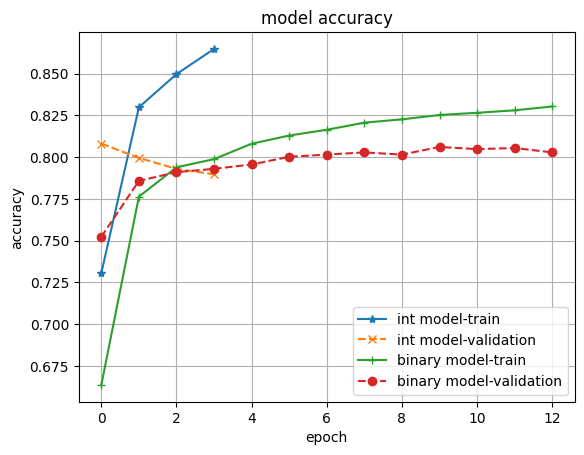

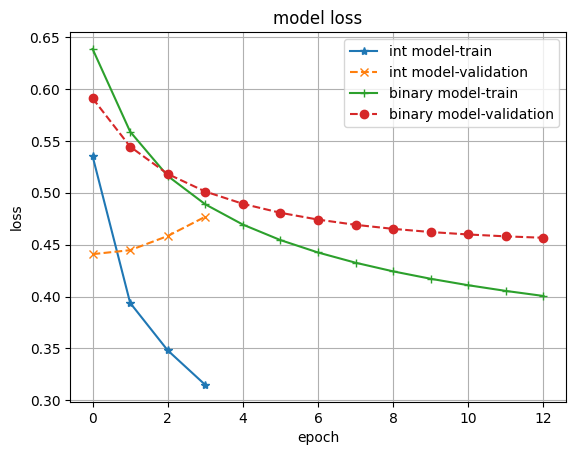

In [38]:
plot_accuracy(binary_history.history,int_history.history)
plot_loss(binary_history.history,int_history.history)

Refer to the tutorial, to make the probability more obvious, a softmax layer is added as the latest layer of the model.

In [39]:
binary_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 1000)             0         
 ectorization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


In [40]:
int_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 16)           16016     
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            2592      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                

## Test
From the training result, the binary model has higher validation accuracy and there is no significant indication of overfitting.
So the binary model will be used for the testing.
Before testing, a softmax layer is added to the model to make the probability more obvious.
The test images are from the previously prepared test directory.
To make the result clearer, a pandas dataframe is created for the record.

Add softmax layer

In [41]:
binary_model.add(tf.keras.layers.Softmax())

In [42]:
binary_pred = binary_model.predict(np.array(test_df['text']))

 32/102 [========>.....................] - ETA: 0s

2023-02-16 23:59:26.808031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 1s 5ms/step


In [43]:
print(binary_pred.shape)
print(binary_pred)

(3263, 2)
[[0.30730042 0.6926996 ]
 [0.46639493 0.5336051 ]
 [0.24578054 0.7542194 ]
 ...
 [0.20143695 0.79856306]
 [0.329239   0.670761  ]
 [0.61114013 0.38885993]]


In [44]:
submission_df = pd.DataFrame(test_df['id']) 
submission_df['target'] = pd.DataFrame(binary_pred).apply(np.argmax, axis=1)

In [45]:
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [46]:
submission_df['target'].value_counts()

0    2073
1    1190
Name: target, dtype: int64

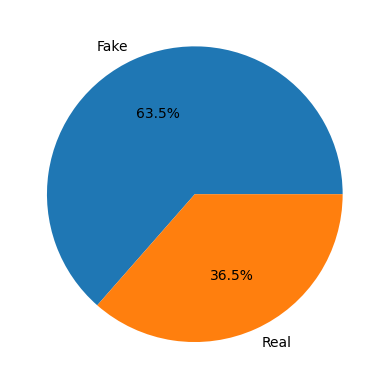

In [47]:
labels = ['Fake', 'Real']
plt.pie(submission_df['target'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show() 

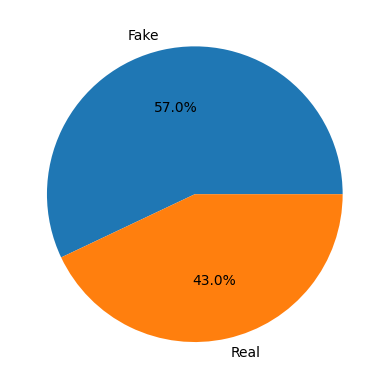

In [48]:
labels = ['Fake', 'Real']
plt.pie(train_df['target'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show() 

In [ ]:
submission_df.to_csv('submission.csv',index=False)

## Conclusion and Analysis
From the statistics information of training data, the percentage of negative and positive are 57% and 43% respectively. The statistics of the predicted testing data indicates the percentage of negative and positive are 63.3% and 36.7% respectively.
As a rough estimation, there's 6% gap between the distribution of the prediction and the real distribution, which means the accuracy of the prediction(testing) is less than 90% (1-6/60), considering there are also some false positive and false negative, the accuracy of the prediction could be around 75% to 80%.
There are some improvements can be applied to get better result.
1. Try different word vector algorithm.
2. Fine tune with trying more different hyper-parameters 
3. Enhance the network